# Handwritten Digits Classification
This project explores classification learning using the MNIST dataset.

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

## 1 Loading Data

In [2]:
from sklearn.datasets import fetch_openml

# Fetch MNIST dataset using sklearn
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

## 2 Analysis

In [3]:
def print_digit(digit):
    # Sample a digit, reshaping the 1x784 array to 28x28
    digit_image = digit.reshape(28, 28)

    # Plot the thing
    plt.imshow(digit_image, cmap='binary')
    plt.axis('off')
    plt.show()

In [4]:
# Convert y from string type to numeric
y = y.astype(np.uint8)

# Separate test and training sets
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

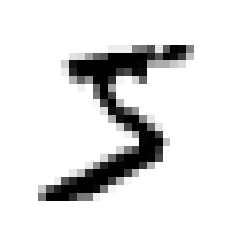

In [7]:
print_digit(X[0])

In [8]:
y[0]

5

In [9]:
# Target vectors for each set for value == 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

## 3 Modeling

In [10]:
# Create pickles directory
os.makedirs(os.path.join(os.path.abspath('.'), 'pickles'), exist_ok=True)

In [11]:
# Stochastic Gradient Descent model for binary '5' classifier
from sklearn.linear_model import SGDClassifier

try:
    # Check for pickled model
    sgd_clf = pickle.load(open('pickles/sgd_clf.pkl', 'rb'))
except FileNotFoundError:
    # Create, train, and pickle the model if it does not exist
    sgd_clf = SGDClassifier(random_state=47)
    sgd_clf.fit(X_train, y_train_5)
    pickle.dump(sgd_clf, open('pickles/sgd_clf.pkl', 'wb'))

In [12]:
# 5 from above
sgd_clf.predict([X[0]])

array([ True])

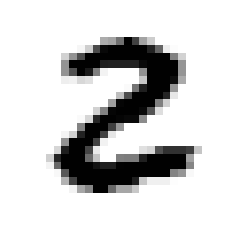

In [13]:
print_digit(X[25])

In [14]:
sgd_clf.predict([X[25]])

array([False])

## 4 Evaluation

### 4.1 Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score

try:
    # Check for pickled cross validation scores
    sgd_cross_val_score = pickle.load(open('pickles/sgd_cross_val_score.pkl', 'rb'))
except FileNotFoundError:
    # Create and pickle the scores if the file does not exist
    sgd_cross_val_score = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')
    pickle.dump(sgd_cross_val_score, open('pickles/sgd_cross_val_score.pkl', 'wb'))

sgd_cross_val_score

array([0.9644 , 0.96595, 0.952  ])

In [16]:
# Very basic classifier for comparison
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [17]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Only ~10% of the dataset is 5, so even if this model guessed 'not 5' every time it would still be ~90% accurate. This demonstrates that accuracy is not a great performance metric for classifiers.

### 4.2 Confusion Matrix

Record of the number of times class A is classified as class B.

In [18]:
# Visualization: Two of ten 'not-5' are classified as '5'
pd.DataFrame(np.array([[8,2],[0,0]]), columns=['not-5','5'], index=['not-5','5'])

,not-5,5
not-5,8,2
5,0,0


In [19]:
# Generate some predictions from the y_train_5 set
from sklearn.model_selection import cross_val_predict

try:
    # Check for pickled predictions
    y_train_pred = pickle.load(open('pickles/y_train_pred.pkl', 'rb'))
except FileNotFoundError:
    # Create and pickle the predictions if the file does not exist
    y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
    pickle.dump(y_train_pred, open('pickles/y_train_pred.pkl', 'wb'))

In [20]:
# Generate a confusion matrix using the predictions
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53852,   727],
       [ 1626,  3795]], dtype=int64)

A perfect classifier would contain non-zero values only along the identity matrix.

In [21]:
# Generate a confusion matrix for a 'perfect' classifier
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

### 4.3 Precision and Recall

*Precision* is the accuracy of the positive predictions.

\begin{equation*}
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}}
\end{equation*}

*Recall* is the ratio of correctly detected positive instances.

\begin{equation*}
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
\end{equation*}

In [22]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8392304290137107

So when the model predicts a 5, it is correct 83.9% of the time.

In [23]:
recall_score(y_train_5, y_train_pred)

0.7000553403431101

Only 70% of the 5s are detected.

The F<sub>1</sub> score represents a combination (harmonic mean) of the precision and recall.

\begin{equation*}
F_1 
= \frac{2}{\frac{1}{Precision} + \frac{1}{Recall}} 
= \frac{\text{True Positives}}{\text{True Positives} + \frac{\text{False Negatives + False Positives}}{2}}
\end{equation*}

The F<sub>1</sub> score will only be high if both recall and precision are high.

In [26]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7633511012772803

### 4.4 Precision/Recall Trade-off

Achieving a high precision or recall score usually demands sacrificing one for the other. Depending on the application, an especially high precision score may be worth a poor recall score or vice versa.

- A high precision classifier would be more prone to missing true predictions, but would return very few false predictions.
- A high recall classifier would include more false predictions, but would be less likely to miss any true predictions.

In [43]:
# Decision scores are measured against a threshold to determine positive or negative classification
y_scores = sgd_clf.decision_function(X[:5])
y_scores

array([  1909.08072371, -10693.83133216, -14330.61396627,  -6577.95302654,
        -8273.37399553])

In [67]:
# SGDClassifier uses threshold 0
y_train_pred[:5]

array([ True, False, False, False, False])

To select an appropriate threshold for the application, it's useful to visualize the trade-off between precision and recall.

In [70]:
# Cross-validate using decision function to get scores instead of predictions
try:
    # Check for pickled scores
    y_scores = pickle.load(open('pickles/y_scores.pkl', 'rb'))
except FileNotFoundError:
    # Create and pickle the scores if the file does not exist
    y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
    pickle.dump(y_scores, open('pickles/y_scores.pkl', 'wb'))

In [73]:
# Create some visualizations for precision, recall, and thresholds
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

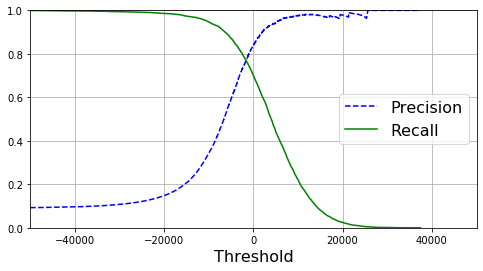

In [81]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

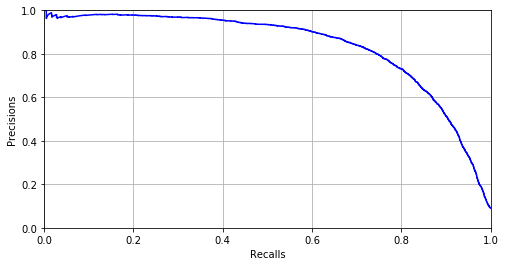

In [83]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, 'b-')
    plt.xlabel('Recalls')
    plt.ylabel('Precisions')
    plt.grid(True)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [88]:
# Helper function to get threshold necessary for target precision
def get_threshold_from_precision(thresholds, precisions, target):
    return thresholds[np.argmax(precisions >= target)]

# Another to print the results
def print_resulting_metrics(thresholds, precisions, target):
    target_threshold = get_threshold_from_precision(thresholds, precisions, target)
    y_train_pred_target = (y_scores >= target_threshold)
    print(
        f'Threshold: {target_threshold}\n'
        f'Precision: {precision_score(y_train_5, y_train_pred_target)}\n'
        f'Recall: {recall_score(y_train_5, y_train_pred_target)}'
    )

# Get a threshold for 90% precision and test it against predictions
print_resulting_metrics(thresholds, precisions, 0.9)

Threshold: 1952.503877999998
Precision: 0.9000273897562312
Recall: 0.6061612248662608


In [89]:
# Try 95%
print_resulting_metrics(thresholds, precisions, 0.95)

Threshold: 5310.608171242331
Precision: 0.9501022494887525
Recall: 0.4285187234827523
